In [3]:
%matplotlib inline
import sys, os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu,compiledir_format="ipynb_compiledir_%(platform)s-%(processor)s-%(python_version)s-%(python_bitwidth)s"'
sys.path.append(os.getcwd()+"/..")

from tasks import check as load_filename
from scripts.imgtovideo import imgs_to_video
from data import load_data
from helpers import salt_and_pepper

import matplotlib.pyplot as plt
import numpy as np

import theano
import theano.tensor as T

from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images

from IPython.display import HTML, Image

import pandas as pd

from tqdm import tqdm

import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

def load_model(filename, **kw):

    model = load_filename(
        what="notebook", 
        filename=filename, 
        **kw
    )
    return model

def build_brush_func(layers):
    if 'biased_output' in layers:
        bias = layers['biased_output'].b.get_value()
    elif 'bias' in layers:
        bias = layers['bias'].b.get_value()
    else:
        bias = np.array(0.1)

    bias = bias[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    if 'scaled_output' in layers:
        scale = layers['scaled_output'].scales.get_value()
    elif 'scale' in layers:
        scale = layers['scale'].scales.get_value()
    else:
        scale = np.array((1.,))
    scale = scale[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    
    X = T.tensor4()

    B = L.get_output(layers['brush'], X)
    if len(layers['brush'].output_shape) == 4: # (ex, t, w, h)
        B = B.dimshuffle(0, 1, 'x', 2, 3)
    
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(B * scale + bias)
    )
    return fn

def build_encode_func(layers):
    w = layers['output'].output_shape[2]
    X = T.tensor4()
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(L.get_output(layers['coord'], X)[:, :, 0:2]) * w
    )
    return fn

def to_grid_of_images(seq_imgs, **kw):
    y = seq_imgs
    imgs = []
    for t in range(y.shape[1]):
        yy = y[:, t]
        if yy.shape[1] == 1:
            yy = yy[:, 0, :, :, np.newaxis] * np.ones((1, 1, 1, 3))
        else:
            yy = yy.transpose((0, 2, 3, 1))
        img = dispims_color(yy, **kw)
        imgs.append(img)
    return imgs

def seq_to_video(seq, filename='out.mp4', verbose=1, framerate=8, rate=8, **kw):
    # shape of seq should be : (examples, time, c, w, h)
    seq = to_grid_of_images(seq, **kw)
    seq = [np.zeros_like(seq[0])] + seq
    if os.path.exists(filename):
        os.remove(filename)
    imgs_to_video(seq, out=filename, verbose=verbose, framerate=framerate, rate=rate)

def embed_video(filename):
    video = open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii')))
def disp_grid(imgs, **kw):
    # shape of imgs should be : (examples, color, w, h)
    out = dispims_color(imgs.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), **kw)
    return out
def normalize(img):
    img = img.copy()
    img -= img.min()
    img /= img.max()
    return img

from lasagnekit.datasets.mnist import MNIST
from skimage.util import pad
from IPython import display
from skimage.transform import resize


In [14]:
model_a1, data, layers, w, h, c = load_model("../training/fractal/a/model.pkl", 
                                            dataset="rescaled_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 16, 16)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [4]:
model_b1, data, layers, w, h, c = load_model("../training/fractal/b/model.pkl", 
                                            dataset="random_cropped_digits", 
                                            force_w=8, force_h=8)

Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 64))
loaded
(128, 128, (128000, 64))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 8, 8)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [29]:
model_b2, data, layers, w, h, c = load_model("../training/fractal/b2/model.pkl", 
                                            dataset="random_cropped_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 256))
loaded
(128, 128, (128000, 256))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 16, 16)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [30]:
model_b3, data, layers, w, h, c = load_model("../training/fractal/b3/model.pkl", 
                                            dataset="random_cropped_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 256))
loaded
(128, 128, (128000, 256))
Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 500, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [5]:
model_a2, data, layers, w, h, c = load_model("../training/fractal/a2/model.pkl", 
                                            dataset="rescaled_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 500, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [6]:
model_a3, data, layers, w, h, c = load_model("../training/fractal/a3/model.pkl", 
                                            dataset="rescaled_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 500, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [7]:
model_a4, data, layers, w, h, c = load_model("../training/fractal/a4/model.pkl", 
                                            dataset="rescaled_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 500, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [8]:
model_a5, data, layers, w, h, c = load_model("../training/fractal/a5/model.pkl", 
                                            dataset="rescaled_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 500, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [9]:
def downscale(x, scale=2):
    h, w = x.shape
    x = x.reshape((h / scale, scale, w / scale, scale))
    return x.mean(axis=(1, 3)), (x - x.mean(axis=(1, 3), keepdims=True)).reshape((h, w))

def downscale_simple(x, scale=2):
    h, w = x.shape
    return x[::scale, ::scale]    
    
def upscale(x, r):
    shape = r.shape
    y_scale = r.shape[0] / x.shape[0]
    x_scale = r.shape[1] / x.shape[1]        
    r = r.reshape((r.shape[0] / y_scale, y_scale, r.shape[1] / x_scale, x_scale))
    x = x.reshape((x.shape[0], 1, x.shape[1], 1))
    return (x + r).reshape(shape)

def upscale_simple(x, scale=2):
    y = np.zeros((x.shape[0]*scale, x.shape[1]*scale))
    y[::scale, ::scale] = x
    return y

## new

In [2]:
# BEGINS with a = trained on rescaled digits
# BEGINS with b = trained on crops of digits
neuralnets = [
    {'model': model_b1, 'on': 'crops',  'padlen': 3,  'nb_iter': 1,  'thresh': 'moving', 'when': 'always'},
    {'model': model_a1, 'on': 'crops',  'padlen': 3,  'nb_iter': 1, 'thresh': 'moving', 'when': 'always'},
]
whitepx_ratio = 0.5
def gen(neuralnets, nb_iter=10, w=32, h=32, init='random'):    
    out_img = np.random.uniform(size=(h, w)) if init == 'random' else init
    snapshots = []
    nb_full = 0
    for i in range(nb_iter):
        
        #snapshots.append(out_img.copy())
        
        for nnet in neuralnets:
            when = nnet.get('when', 'always')
            if type(when) == list:
                allow = False
                for w in when:
                    if type(w) == tuple:
                        w1 = int(w[0] * nb_iter)
                        w2 = int(w[1] * nb_iter)
                        if (i >= w1 and i < w2):
                            allow = True
                    else:
                        w = int(w*nb_iter)
                        if i == w:
                            allow = True    
                if not allow:
                    continue
            model = nnet['model']
            on = nnet['on']
            patch_h, patch_w = model.layers['output'].output_shape[2:]
            nb_iter_local = nnet.get('nb_iter', 10)
            thresh = nnet.get('thresh', 0.5)
            if on == 'crops':
                padlen = nnet.get('padlen', 5) 
                img = pad(out_img, padlen, 'constant', constant_values=(0, 0))
                py = np.random.randint(0, img.shape[0] - patch_h)
                px = np.random.randint(0, img.shape[1] - patch_w)
                patch = img[py:py + patch_h, px:px + patch_w]
                patch = patch[np.newaxis, np.newaxis, :, :]
                patch = patch.astype(np.float32)
                noise = nnet.get('noise', 0)
                for _ in range(nb_iter_local):
                    if noise:patch *= np.random.uniform(size=patch.shape)<=(1-noise)
                    patch = model.reconstruct(patch)
                    
                    if thresh == 'moving':
                        vals = patch.flatten()
                        vals = vals[np.argsort(vals)]
                        thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
                    else:
                        thresh_ = thresh
                    if thresh: patch = patch > thresh_
                    patch = patch.astype(np.float32)
                img[py:py + patch_h, px:px + patch_w] = patch[0, 0]
                out_img[:, :] = img[padlen:-padlen, padlen:-padlen]
            elif on == 'full':
                nb_full += 1
                scale = h / model.layers['output'].output_shape[2]
                #img, resid = downscale(out_img, scale=scale)
                img = downscale_simple(out_img, scale=scale)
                img = img[np.newaxis, np.newaxis, :, :]
                img = img.astype(np.float32)
                for _ in range(nb_iter_local):
                    img = model.reconstruct(img)
                    
                    if thresh == 'moving':
                        vals = img.flatten()
                        vals = vals[np.argsort(vals)]
                        thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
                    else:
                        thresh_ = thresh

                    if thresh:img = img > thresh_
                    
                img = img[0, 0]
                #resid[:]=0
                #print(img.shape)
                img = upscale_simple(img, scale=scale)
                #print(img.shape)

                #img = normalize(img)
                img = img > thresh_
                img = img.astype(np.float32)
                out_img = img
    return out_img, snapshots
imgs = []
for i in range(1):
    img, snap = gen(neuralnets, nb_iter=20000, w=2**9, h=2**9, init='random')
    imgs.append(img)

NameError: name 'model_b1' is not defined

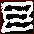

In [34]:
img = disp_grid(np.array(imgs)[:, None, :, :], 
                border=1,
                bordercolor=(0.3, 0, 0))
imsave('out.png', img)
Image('out.png', width=100, height=100)

In [12]:
seq_to_video(np.array(snap)[np.newaxis, :, np.newaxis], 'out.mp4')
embed_video('out.mp4')

IndexError: list index out of range

## old

In [ ]:
sw, sh = 8, 8
h, w = 16, 16
scale = 2

imgs = []
np.random.seed(2)
for K in range(25):
    x = np.random.uniform(0, 1, size=(h*scale, w*scale))
    #x = resize(data_orig.X[0].reshape((28, 28)), (32, 32))
    nb_iter = 300
    for i in range(nb_iter):

        if i % (nb_iter/2) == 0 and i > 0:
            # up
            x_new, resid = downscale(x, scale=scale)
            x_new = downscale_simple(x, scale=scale)
            x_new = x_new[np.newaxis, np.newaxis, :, :]
            x_new = x_new.astype(np.float32)

            for _ in range(10):
                
                x_new = model_a1.reconstruct(x_new)
                x_new = x_new > 0.48
                x_new = x_new.astype(np.float32)

            x_new = x_new[0, 0]
            #resid[:]=0
            x_new = upscale(x_new, resid)
            #print(x_new.min(), x_new.max())
            x  = x_new
            x = x > 0.5

        padlen = 3
        x_ = pad(x, padlen, 'constant', constant_values=(0, 0))
        
        py = np.random.randint(0, x_.shape[0] - sh)
        px = np.random.randint(0, x_.shape[0] - sw)
        patch = x_[py:py+sh, px:px+sw]#.copy()
        #print(x.shape, patch.shape)
        patch = patch[np.newaxis, np.newaxis, :, :]
        patch = patch.astype(np.float32)
        
        
        for _ in range(1):
            patch += np.random.uniform(0, 0.05, size=patch.shape)
            patch = model_b1.reconstruct(patch)
            patch = patch > 0.5
            patch = patch.astype(np.float32)
        x_[py:py+sh, px:px+sw] = patch[0, 0]
        
        x[:, :] = x_[padlen:-padlen, padlen:-padlen]
        x = x > 0.5
        #display.clear_output(wait=True)
        #plt.imshow(x, cmap='gray', interpolation='none')
        #display.display(plt.gcf())
    imgs.append(x)
#display.clear_output(wait=True)

In [ ]:
img = disp_grid(np.array(imgs)[:, None, :, :], 
                border=1,
                bordercolor=(0.3, 0, 0))
imsave('out.png', img)
Image('out.png', width=400, height=400)

## refinement

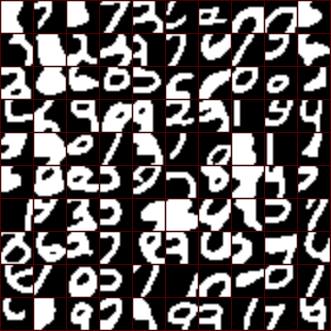

In [39]:
from skimage.transform import rescale
x = np.random.uniform(size=(10*10, 1, 16, 16)).astype(np.float32)
iters = []
thresh = 'moving'
whitepx_ratio=0.4
for i in range(10):
    x  = model_b2.reconstruct(x)
    
    if thresh == 'moving':
        vals = x.flatten()
        vals = vals[np.argsort(vals)]
        thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
    else:
        thresh_ = thresh
    x = x>thresh_
    #x = np.random.uniform(size=x.shape)<=x
    iters.append(x.copy())

x_r = np.empty((x.shape[0], 1, 32, 32))
for i in range(len(x)):
    x_r[i, 0] = resize(x[i, 0], (32, 32))
#x_r = x_r > t
x_r = x_r.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
img = dispims_color(x_r, border=1, bordercolor=(0.3, 0.0, 0.0))
imsave('out.png', img)
Image('out.png')

In [42]:
!rm out.mp4
iters = map(disp_grid, iters)
imgs_to_video(iters, out='out.mp4', verbose=1, framerate=8, rate=8)
embed_video('out.mp4')

rm: cannot remove `out.mp4': No such file or directory


ValueError: axes don't match array

In [43]:
h = x.reshape((x.shape[0], -1))
def hash_array(x):
    return hash(tuple(x))
h = map(hash_array, h)
len(set(h)) / float(len(x))

1.0